## Neural Quantum Embedding

For quantum machine learning (QML) with classical data, we must initially map classical data into a quantum state. In this [paper[1]](https://arxiv.org/abs/2311.11412), we show the importance of quantum embedding and emphasizes the necessity of trainable data-dependent quantum embedding. We present Neural Quantum Embedding (NQE), which utilizes classical neural network to efficiently optimize quantum embeddign for given datasets. This is the introductory tutorial, the full code and experimental results can be found in this [Github repository](https://github.com/takh04/neural-quantum-embedding).

*Following tutorial was tested under environment:*
```
python==3.10
pennylane==0.30.0
torch==2.7.1
tensorflow==2.19.0
scikit-learn==1.7.0
seaborn==0.13.2
```


### 0.Data loading and preprocessing

For this problem, we will use MNIST image datasets. Additionally, we will use Principle Component Analysis (PCA) to reduce the dimension of the data.

In [1]:
import pennylane as qml
from pennylane import numpy as np
import torch
from torch import nn
from sklearn.decomposition import PCA
import tensorflow as tf

np.random.seed(42)
torch.manual_seed(42)
def data_load_and_process():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
    x_train, x_test = x_train[..., np.newaxis] / 255.0, x_test[..., np.newaxis] / 255.0
    train_filter_tf = np.where((y_train == 0 ) | (y_train == 1 ))
    test_filter_tf = np.where((y_test == 0 ) | (y_test == 1 ))
 
    x_train, y_train = x_train[train_filter_tf], y_train[train_filter_tf]
    x_test, y_test = x_test[test_filter_tf], y_test[test_filter_tf]

    x_train = tf.image.resize(x_train[:], (256, 1)).numpy()
    x_test = tf.image.resize(x_test[:], (256, 1)).numpy()
    x_train, x_test = tf.squeeze(x_train).numpy(), tf.squeeze(x_test).numpy()
        
    X_train = PCA(4).fit_transform(x_train)
    X_test = PCA(4).fit_transform(x_test)
    x_train, x_test = [], []
    for x in X_train:
        x = (x - x.min()) * (np.pi / (x.max() - x.min()))
        x_train.append(x)
    for x in X_test:
        x = (x - x.min()) * (np.pi / (x.max() - x.min()))
        x_test.append(x)
    return x_train, x_test, y_train, y_test

#load data
X_train, X_test, Y_train, Y_test = data_load_and_process()
X_train, X_test, Y_train, Y_test = X_train[0:400], X_test[0:100], Y_train[0:400], Y_test[0:100]

### 1. Neural Quantum Embedding

NQE utilizes trainable classical neural networks along with a quantum embedding circuit. The goal of NQE is find the optimal embedding that maximizes the trace distance between two data ensembles. Training the NQE with trace distance directly as a cost function is ideal, but calculating the trace distance is expensive even with the quantum computer. Here, we will use implicit loss function, inspired by fidelity overlap between two data class.

![Alt text for the image](nqe.png)

Although NQE scheme can be applied on general quantum embedding, we will focus on IQP type embedding introduced by [Havlicek et al.[2]](https://arxiv.org/abs/1804.11326). This is a widely used quantum embedding scheme for QML due to its classical intractability. First, we define a IQP type quantum embedding.

In [2]:
N_layers = 3
# exp(ixZ) gate
def exp_Z(x, wires):
    qml.RZ(-2 * x, wires=wires)

# exp(i(pi - x1)(pi - x2)ZZ) gate
def exp_ZZ(x1, x2, wires):
    qml.CNOT(wires=wires)
    qml.RZ(-2 * (np.pi - x1) * (np.pi - x2), wires=wires[1])
    qml.CNOT(wires=wires)

def QuantumEmbedding(input):
    for i in range(N_layers):
        for j in range(4):
            qml.Hadamard(wires=j)
            exp_Z(input[j], wires=j)
        for k in range(3):
            exp_ZZ(input[k], input[k+1], wires=[k,k+1])
        exp_ZZ(input[3], input[0], wires=[3, 0])

For NQE, we construct a hybrid circuit by concatenating fully classical neural network with quantum embedding circuit. Then, we construct a quantum circuit that measures the fidleity overlap between two embedded quantum states.

In [3]:
dev = qml.device('default.qubit', wires=4)
@qml.qnode(dev, interface="torch")
def circuit(inputs): 
    QuantumEmbedding(inputs[0:4])
    qml.adjoint(QuantumEmbedding)(inputs[4:8])
    return qml.probs(wires=range(4))

class Model_Fidelity(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer1 = qml.qnn.TorchLayer(circuit, weight_shapes={})
        self.linear_relu_stack1 = nn.Sequential(
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8,8),
            nn.ReLU(),
            nn.Linear(8,4)
        )
    def forward(self, x1, x2):
        x1 = self.linear_relu_stack1(x1)
        x2 = self.linear_relu_stack1(x2)
        x = torch.concat([x1, x2], 1)
        x = self.qlayer1(x)
        return x[:,0]

### 2. Optimize NQE

Now we optimize the quantum embedding by training the classical neural network part of NQE. We will train for 200 iterations with batch size of 25.

In [4]:
batch_size = 25
iterations = 200


#make new data for hybrid model
def new_data(batch_size, X, Y):
    X1_new, X2_new, Y_new = [], [], []
    for i in range(batch_size):
        n, m = np.random.randint(len(X)), np.random.randint(len(X))
        X1_new.append(X[n])
        X2_new.append(X[m])
        if Y[n] == Y[m]:
            Y_new.append(1)
        else:
            Y_new.append(0)
    X1_new, X2_new, Y_new = torch.tensor(X1_new).to(torch.float32), torch.tensor(X2_new).to(torch.float32), torch.tensor(Y_new).to(torch.float32)
    return X1_new, X2_new, Y_new


model = Model_Fidelity()
model.train()

loss_fn = torch.nn.MSELoss()
opt = torch.optim.SGD(model.parameters(), lr=0.01)
for it in range(iterations):
    X1_batch, X2_batch, Y_batch = new_data(batch_size, X_train, Y_train)
    pred = model(X1_batch, X2_batch)
    loss = loss_fn(pred, Y_batch)

    opt.zero_grad()
    loss.backward()
    opt.step()

    if it % 50 == 0:
        print(f"Iterations: {it} Loss: {loss.item()}")

    
torch.save(model.state_dict(), "model.pt")


/var/folders/s2/t3n82l2s329dh9dttmtv7vr00000gn/T/ipykernel_19536/422545311.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  X1_new, X2_new, Y_new = torch.tensor(X1_new).to(torch.float32), torch.tensor(X2_new).to(torch.float32), torch.tensor(Y_new).to(torch.float32)


Iterations: 0 Loss: 0.28621241450309753
Iterations: 50 Loss: 0.09293991327285767
Iterations: 100 Loss: 0.04241776466369629
Iterations: 150 Loss: 0.06826834380626678


### 3. Effectiveness of NQE in QML

Let's assess the effectiveness of optimized quantum embedding in QML. Here, we will use [quantum convolutional neural networks (QCNN)[3]](https://arxiv.org/abs/2108.00661). For more information about QCNN, have a look at [this tutorial](https://takh04.github.io/QCNN_tutorial.html).

In [5]:
Y_train = [-1 if y == 0 else 1 for y in Y_train]
Y_test = [-1 if y == 0 else 1 for y in Y_test]

In [6]:
class x_transform(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack1 = nn.Sequential(
            nn.Linear(4, 8),
            nn.ReLU(),
            nn.Linear(8, 8),
            nn.ReLU(),
            nn.Linear(8, 4)
        )
    def forward(self, x):
        x = self.linear_relu_stack1(x)
        return x.detach().numpy()

model_transform = x_transform()
model_transform.load_state_dict(torch.load("model.pt"))

<All keys matched successfully>

Define a QCNN model with SU4 ansatz. We will compare IQP embedding to IQP embedding with NQE.

In [7]:
def statepreparation(x, NQE):
    if NQE:
        x = model_transform(torch.tensor(x))
    QuantumEmbedding(x)

def U_SU4(params, wires): # 15 params
    qml.U3(params[0], params[1], params[2], wires=wires[0])
    qml.U3(params[3], params[4], params[5], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[6], wires=wires[0])
    qml.RZ(params[7], wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[0]])
    qml.RY(params[8], wires=wires[0])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.U3(params[9], params[10], params[11], wires=wires[0])
    qml.U3(params[12], params[13], params[14], wires=wires[1])
    
def QCNN(params):    
    param1 = params[0:15]
    param2 = params[15:30]
    
    U_SU4(param1, wires=[0, 1])
    U_SU4(param1, wires=[2, 3])
    U_SU4(param1, wires=[1, 2])
    U_SU4(param1, wires=[3, 0])
    U_SU4(param2, wires=[0, 2])
    

@qml.qnode(dev)
def QCNN_classifier(params, x, NQE):
    statepreparation(x, NQE)
    QCNN(params)
    return qml.expval(qml.PauliZ(2))

Train QCNN for 100 iterations with learning rate 0.01 and batch size 25 using linear loss function.

In [8]:
steps = 100
learning_rate = 0.01
batch_size = 25

def Linear_Loss(labels, predictions):
    loss = 0
    for l,p in zip(labels, predictions):
        loss += 0.5 * (1 - l * p)
    return loss / len(labels)

def cost(weights, X_batch, Y_batch, Trained):
    preds = [QCNN_classifier(weights, x, Trained) for x in X_batch]
    return Linear_Loss(Y_batch, preds)


def circuit_training(X_train, Y_train, Trained):
    weights = np.random.random(30, requires_grad = True)
    opt = qml.NesterovMomentumOptimizer(stepsize=learning_rate)
    loss_history = []
    for it in range(steps):
        batch_index = np.random.randint(0, len(X_train), (batch_size,))
        X_batch = [X_train[i] for i in batch_index]
        Y_batch = [Y_train[i] for i in batch_index]
        weights, cost_new = opt.step_and_cost(lambda v: cost(v, X_batch, Y_batch, Trained),
                                                     weights)
        loss_history.append(cost_new)
        if it % 50 == 0:
            print("iteration: ", it, " cost: ", cost_new)
    return loss_history, weights

Compare training with and without NQE.

In [9]:
loss_history_without_NQE, weight_without_NQE = circuit_training(X_train, Y_train, Trained=False)
loss_history_with_NQE, weight_with_NQE = circuit_training(X_train, Y_train, Trained=True)

/Users/tak/anaconda3/envs/new/lib/python3.10/site-packages/autograd/numpy/numpy_vjps.py:943: ComplexWarning: Casting complex values to real discards the imaginary part
  onp.add.at(A, idx, x)


iteration:  0  cost:  0.47305071882302285
iteration:  50  cost:  0.4285454994628626
iteration:  0  cost:  0.613197452123183
iteration:  50  cost:  0.3265755233817129


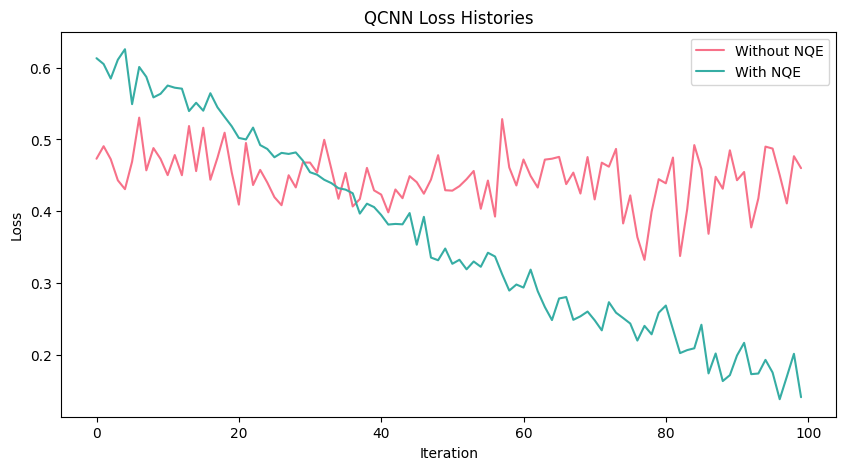

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 5]
fig, ax = plt.subplots()
clrs = sns.color_palette("husl", 2)
with sns.axes_style("darkgrid"):
    ax.plot(range(len(loss_history_without_NQE)), loss_history_without_NQE, label="Without NQE", c=clrs[0])
    ax.plot(range(len(loss_history_with_NQE)), loss_history_with_NQE, label="With NQE", c=clrs[1])

ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
ax.set_title("QCNN Loss Histories")
ax.legend()

We can see that the loss history is much lower when NQE is employed. Now let's see how well QCNN can classify the MNIST image data.

In [11]:
def accuracy_test(predictions, labels):
    acc = 0
    for l, p in zip(labels, predictions):
        if np.abs(l - p) < 1:
            acc = acc + 1
    return acc / len(labels)


accuracies_without_NQE, accuracies_with_NQE = [], []

prediction_without_NQE = [QCNN_classifier(weight_without_NQE, x, NQE=False) for x in X_test]
prediction_with_NQE = [QCNN_classifier(weight_with_NQE, x, NQE=True) for x in X_test]

accuracy_without_NQE = accuracy_test(prediction_without_NQE, Y_test) * 100
accuracy_with_NQE = accuracy_test(prediction_with_NQE, Y_test) * 100

In [12]:
print(f"Accuracy without NQE: {accuracy_without_NQE:.3f}")
print(f"Accuracy with NQE: {accuracy_with_NQE:.3f}")

Accuracy without NQE: 61.000
Accuracy with NQE: 98.000


Classification accuracy with NQE is significantly larger than the classification accuracy without NQE! If you want to how NQE affects training loss lower bound, trainability, generalization performance of QML models have a look at the original paper and the code!

### References

1. Tak Hur, Israel F. Araujo, Daniel K. Park. *Neural Quantum Embedding: Pushing the Limits of Quantum Supervised Learning*. Physical Review A (2024).

2. Vojtech Havlicek, Antonio D. C ́orcoles, Kristan Temme, Aram W. Harrow, Abhinav Kandala, Jerry M. Chow, and Jay M. Gambetta. *Supervised learning with quantum-enhanced feature spaces*. Nature (2019).

### Citation

If you use this code in research, please cite our paper:

```
@article{hur2024neural,
  title={Neural quantum embedding: Pushing the limits of quantum supervised learning},
  author={Hur, Tak and Araujo, Israel F and Park, Daniel K},
  journal={Physical Review A},
  volume={110},
  number={2},
  pages={022411},
  year={2024},
  publisher={APS}
}
```